In [10]:
# Basics libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classification ML Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [11]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):

    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def import_data(csv): 
    
    df = pd.read_csv(csv)
    df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.drop('date', axis=1)
    
    close_columns = []
    high_columns = []
    low_columns = []
    open_columns = []
    volume_columns = []
    open_int_columns = []

    for i in df.columns:
        if "close" in i:
            close_columns.append(i)
        elif "high" in i:
            high_columns.append(i)
        elif "low" in i:
            low_columns.append(i)
        elif "open_int" in i:
            open_int_columns.append(i)
        elif "open" in i:
            open_columns.append(i)
        elif "volume" in i:
            volume_columns.append(i)

    close_df = df[close_columns]
    high_df = df[high_columns]
    low_df = df[low_columns]
    open_df = df[open_columns]
    volume_df = df[volume_columns]
    open_int_df = df[open_int_columns]
    
    return [close_df, high_df, low_df, open_df, volume_df, open_int_df]

def garman_klass_vol(high_df, low_df, close_df, open_df, period=60):
    """
    Estima a volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento
    """
    # Calculando parcelas internas da somatoria
    x_hl = (1/2)*(np.log(np.divide(high_df, low_df))) ** 2
    x_co = - (2 * np.log(2) - 1)* (np.log(np.divide(close_df, open_df))**2)
    
    # Somando parcelas calculadas
    x = x_hl + x_co.values
    
    x.columns = [x[0:3] + "gk" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    gk = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1/period
    
    # Atribuindo not a number, para os valores iniciais
    gk.iloc[:period,:] = np.nan
    
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        gk.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return gk

def parkinson_vol(high_df, low_df, period=60):
    """
    Estimando a volatilidade a partir dos preço de Alta e de Baixa
    """
    
    # Calculando parcela interna da somatoria
    x = np.log(np.divide(high_df, low_df)) ** 2
    x.columns = [x[0:3] + "pv" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    pv = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1 / (4 * period * np.log(2))
    
    # Atribuindo not a number, para os valores iniciais
    pv.iloc[:period,:] = np.nan
        
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        pv.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return pv

def monthly_volume(volume, period=20):
    
    daily_volume = volume.copy()
    
    for row in range(period, len(volume)):
        daily_volume.iloc[row] = volume.iloc[row-period:row,:].cumsum().iloc[-1]
        
    monthly_volume = daily_volume.resample("BM").last().ffill()
    
    return monthly_volume
    

In [12]:
close_df, high_df, low_df, open_df, volume_df, open_int_df = import_data("data.csv")

# Retornos diários
returns_daily = close_df.pct_change().fillna(0)

# Retornos mensais
returns_monthly = close_df.pct_change(20).fillna(0).resample('BM').last().ffill()

# Vol diária
vol_daily = returns_daily.ewm(adjust=True, com=60, min_periods=0).std().dropna()

# Vol de 261 dias, apenas o último dia de cada mês
vol_monthly = (np.sqrt(261)*vol_daily).resample('BM').last().ffill()

pv_df = parkinson_vol(high_df, low_df)
pv_monthly = (np.sqrt(261)*pv_df).resample('BM').last().ffill()

gk_df = garman_klass_vol(high_df, low_df, close_df, open_df)
gk_monthly = (np.sqrt(261)*gk_df).resample('BM').last().ffill()

monthly_volume = monthly_volume(volume_df)

## Feature Engineering

In [13]:
def train_test(stock):
    train = pd.DataFrame()

    train["Returns Monthly"] = returns_monthly.iloc[:,stock]
    train["EWMA"] = vol_monthly.iloc[:,stock]
    train["Parkinson"] = pv_monthly.iloc[:,stock]
    train["Garman-Klass"] = gk_monthly.iloc[:,stock]
    train["Monthly Volume"] = monthly_volume.iloc[:,stock]

    prices = close_df.iloc[:,stock]

    for lag in [3, 6, 9, 12]:
        train["Momentum " + str(lag)] = prices.pct_change(lag * 21)

    target = train["Returns Monthly"].shift(-1)
    
    features = train.dropna()
    target = target.dropna().loc['2000-07-31':]
    
    return (features, target)

# Visualization


In [14]:
features, target = train_test(1)
df = features
df["target"] = np.sign(target)

In [15]:
features.head()

,Returns Monthly,EWMA,Parkinson,Garman-Klass,Monthly Volume,Momentum 3,Momentum 6,Momentum 9,Momentum 12,target
date,,,,,,,,,,
2000-07-31,-0.013500,0.081672,0.090117,0.087723,135249.0,-0.051498,-0.084389,-0.095780,-0.052628,-1.0
2000-08-31,-0.031493,0.076585,0.078957,0.080442,137686.0,-0.025209,-0.094248,-0.106080,-0.107423,1.0
2000-09-29,0.010879,0.095101,0.092941,0.094567,227772.0,-0.017524,-0.063966,-0.096061,-0.084917,-1.0
2000-10-31,-0.010391,0.097895,0.104744,0.107019,101142.0,-0.045012,-0.090034,-0.116647,-0.124354,-1.0
2000-11-30,-0.019273,0.092711,0.111326,0.112521,92974.0,-0.043417,-0.050007,-0.119602,-0.133054,1.0


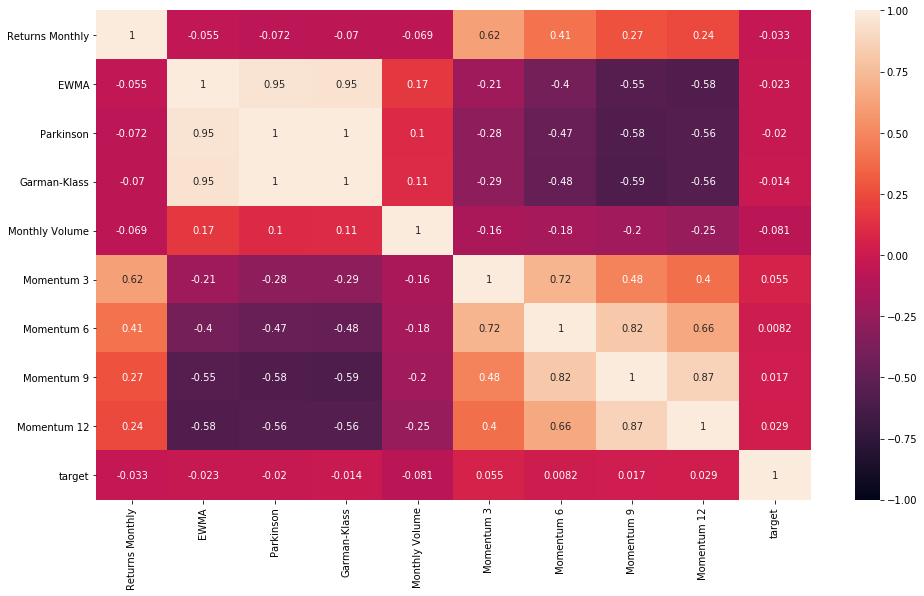

In [16]:
plt.figure(figsize=(16,9))
sns.heatmap(features.corr(), annot=True, vmin=-1, vmax=1)

In [17]:
plt.figure(figsize=(16,9))
sns.scatterplot('Lagged Momentum 12', 'Monthly Volume',
                hue='target',  data=df)

ValueError: Could not interpret input 'Lagged Momentum 12'

<Figure size 1152x648 with 0 Axes>

## Trainning

In [19]:
def backtesting(model, name="MODEL"):
    momentum = []
    prediction = []
    real = []

    for stock in range(54):

        printProgressBar(stock, 53)

        features, target = train_test(stock)

        pred = []
        true = []
        mom = []

        for date in range(100,190):
            
            # **TRAIN DATA**
            # Features
            X = features.iloc[date-36:date]
            
            # Target
            y = np.sign(target.iloc[date-36:date])

            # **TEST DATA**
            # Features
            X_test = features.iloc[date:date+1]
            
            # Target
            y_test = np.sign(target.iloc[date:date+1])

            # Fitting the model
            model.fit(X, y)

            y_pred = model.predict(X_test)

            pred.append(y_pred[0])
            true.append(y_test[0])
            mom.append(np.sign(features["Lagged Momentum 12"].iloc[date-1]))
            
        #print(accuracy_score(mom, true))

        momentum.append(mom)
        prediction.append(pred)
        real.append(true)

    mom_array = np.array(momentum)
    pred_array = np.array(prediction)
    real_array = np.array(real)
    
    
    # Reshaping
    true = real_array.reshape([54*90, 1])
    pred = pred_array.reshape([54*90, 1])
    mom = mom_array.reshape([54*90, 1])

    model_ac = accuracy_score(true, pred)
    model_f1 = f1_score(true, pred)

    mom_ac = accuracy_score(true, mom)
    mom_f1 = f1_score(true, mom)

    print("MOMENTUM")
    print( "Accuracy: ", mom_ac)
    print("F1 Score: ", mom_f1)
    print()
    print(name)
    print("Accuracy: ", model_ac)
    print("F1 Score: ", model_f1)

In [20]:
backtesting(SVC())

KeyError: 'Lagged Momentum 12'

In [421]:
backtesting(RidgeClassifier())

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5333333333333333
F1 Score:  0.6315789473684211

MODEL
Accuracy:  0.5666666666666667
F1 Score:  0.7194244604316546


In [422]:
backtesting(SGDClassifier())

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5333333333333333
F1 Score:  0.6315789473684211

MODEL
Accuracy:  0.5347736625514403
F1 Score:  0.6349103826901341


In [488]:
backtesting(MLPClassifier(solver='lbfgs', 
                          alpha=1e-3, 
                          activation='relu',
                          hidden_layer_sizes=(5, 3), 
                          random_state=1),
           )

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5333333333333333
F1 Score:  0.6315789473684211

MODEL
Accuracy:  0.6111111111111112
F1 Score:  0.7586206896551725


In [ ]:
0.7586206896551725

In [18]:
backtesting(RandomForestClassifier())

KeyboardInterrupt: 